In [ ]:
#simulated version of the experiment which is more pure 

In [1]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [3]:
#Surfaces
'''
# Parametrize a sphere
def sphere_r(u, v):
    return np.array([np.sin(v) * np.cos(u), np.sin(v) * np.sin(u), np.cos(v)])
'''

'''
# Ellipsoid
a,b,c = 3.0,1.5,1.0
def ellipsoid_r(u,v):
    return np.array([a*np.sin(v)*np.cos(u),b*np.sin(v)*np.sin(u),c*np.cos(v)])
'''

'''
#Tannery pear
a=2.0
sqrt_2 = np.sqrt(2)
def pear_r(u,v):
    return np.array([a*np.sin(u)*np.cos(u)*np.cos(v),a*np.sin(u)*np.cos(u)*np.sin(v),2*sqrt_2*a*np.sin(u)])
'''

#Torus
r,r_2 = 10.0,20.0
def torus_r(u,v):
    return np.array([(r_2+r*np.cos(v))*np.cos(u),(r_2+r*np.cos(v))*np.sin(u),r*np.sin(v)])

In [11]:
#must find ranges to close the surface
r_func=torus_r #MAKE SURE TO CHANGE IF NEW SURFACE AND CHANGE RANGES
u_range=(0, 2 * np.pi)
v_range=(0, 2 * np.pi)
Nu=50
Nv=50
cmap='viridis'

In [13]:
# Plot surface with scaled axes
def plot_param_surface(r_func, u_range, v_range, Nu, Nv, cmap='viridis'):
    """
    Plot a 3D parametric surface defined by r_func(u, v) with equal aspect ratio.

    Parameters:
    - r_func : function(u, v) -> np.array([x, y, z])
    - u_range: (u_min, u_max)
    - v_range: (v_min, v_max)
    - Nu, Nv : resolution in u and v
    - cmap    : colormap

    Returns:
    - fig, ax : matplotlib figure and axes objects
    """
    # Create parameter grids
    u = np.linspace(u_range[0], u_range[1], Nu)
    v = np.linspace(v_range[0], v_range[1], Nv)
    U, V = np.meshgrid(u, v)
    
    # Allocate coordinate arrays
    X = np.zeros(U.shape)
    Y = np.zeros(U.shape)
    Z = np.zeros(U.shape)
    
    # Compute surface coordinates
    for i in range(Nv):
        for j in range(Nu):
            X[i, j], Y[i, j], Z[i, j] = r_func(U[i, j], V[i, j])
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    
    # Plot the surface
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cmap, edgecolor='none')
    
    # === aspect‐ratio fix so graph is scaled properly ===
    max_range = np.array([X.max() - X.min(),Y.max() - Y.min(),Z.max() - Z.min()]).max()
    mid_x = 0.5 * (X.max() + X.min())
    mid_y = 0.5 * (Y.max() + Y.min())
    mid_z = 0.5 * (Z.max() + Z.min())
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    # =========================
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Parametric Surface')
    plt.tight_layout()
    plt.show()
    
    return fig, ax

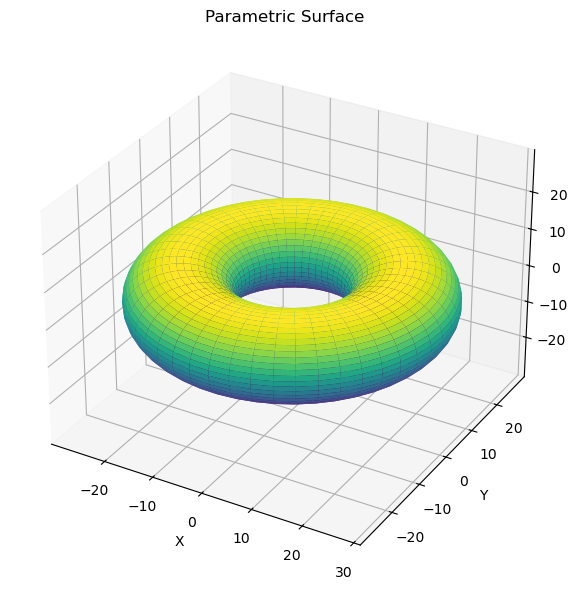

(<Figure size 600x600 with 1 Axes>,
 <Axes3D: title={'center': 'Parametric Surface'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [15]:
plot_param_surface(r_func,u_range,v_range,Nu,Nv,cmap)

In [ ]:
def read_flatworm_direction():
    # replace this stub with real signal‑processing logic.
    # For now it always returns 0.
    return 0,0 # later should return 0 through 6 for no direction or a certain direction
    #also returns a second number for the magnitude 

#read_flatworm_direction()[0],read_flatworm_direction()[1] for direction and magnitude

def movement(point: np.ndarray, direction: int, magnitude: int) -> np.ndarray:
    """
    Moves `point` (a length-3 numpy array) in 3D by magnitude*10 along one axis.
    
    Args:
      point      (np.ndarray): shape (3,), modified in-place
      direction  (int): 0=no move, 1=+x, 2=-x, 3=+y, 4=-y, 5=+z, 6=-z
      magnitude  (int): 1–6
      
    Returns:
      np.ndarray: the same array, after in-place modification
    """
    disp = magnitude

    if direction == 1:      # +x
        point[0] += disp
    elif direction == 2:    # -x
        point[0] -= disp
    elif direction == 3:    # +y
        point[1] += disp
    elif direction == 4:    # -y
        point[1] -= disp
    elif direction == 5:    # +z
        point[2] += disp
    elif direction == 6:    # -z
        point[2] -= disp
    # direction == 0 or any other: no change

    return point

In [ ]:
#These functions give the ability to plot the surface, find the centroid as if the surface were filled in to be uniformly dense, 
#get a magnitude plot of the field from a slice parallel to the xy-plane and plot with the centroid, find if a point is
#inside or outside the surface, and measure the field strength based on whether a point is inside or outside the surface


# 1) Mesh builder that wraps the u-seam
def build_param_mesh_periodic(r_func, u_range, v_range, Nu, Nv):

    """
    Build a closed triangular mesh of the surface by wrapping u at the seam.

    Parameters:
    - r_func   : function(u, v) -> np.array([x, y, z])
    - u_range  : (u_min, u_max)
    - v_range  : (v_min, v_max)
    - Nu, Nv   : resolution in u and v

    Returns:
    - triangles: list of np.ndarray of shape (3,3) representing mesh triangles
    """
    
    umin, umax = u_range
    vmin, vmax = v_range
    us = np.linspace(umin, umax, Nu, endpoint=False)
    vs = np.linspace(vmin, vmax, Nv)
    verts = np.zeros((Nv, Nu, 3))
    for i, v in enumerate(vs):
        for j, u in enumerate(us):
            verts[i,j] = r_func(u, v)
    tris = []
    for i in range(Nv-1):
        for j in range(Nu):
            j2 = (j+1) % Nu
            v0 = verts[i  , j ]
            v1 = verts[i  , j2]
            v2 = verts[i+1, j ]
            v3 = verts[i+1, j2]
            tris.append(np.stack([v0, v1, v3]))
            tris.append(np.stack([v0, v3, v2]))
    return tris



# 2) Find centroid
def compute_volume_centroid(triangles, ref_point=None):
    """
    Compute the volume centroid and total volume of a closed, star-shaped mesh by
    decomposing it into tetrahedra (ref_point, v0, v1, v2), using ABSOLUTE volumes.

    Parameters:
    - triangles : list of np.ndarray shape (3,3), each a mesh triangle [v0, v1, v2]
    - ref_point : np.array([x, y, z]) interior reference point (default origin)

    Returns:
    - centroid  : np.array([x_c, y_c, z_c])
    - total_vol : float
    """
    if ref_point is None:
        ref_point = np.zeros(3)

    total_vol = 0.0
    centroid  = np.zeros(3)

    for v0, v1, v2 in triangles:
        # signed volume of tetrahedron
        vol_signed = np.dot(v0 - ref_point,
                            np.cross(v1 - ref_point,
                                     v2 - ref_point)) / 6.0
        # use absolute to avoid orientation issues
        vol = abs(vol_signed)

        # centroid of that tetrahedron
        tet_centroid = (ref_point + v0 + v1 + v2) / 4.0

        # accumulate
        centroid  += tet_centroid * vol
        total_vol += vol

    centroid /= total_vol
    return centroid, total_vol




#determine if point is inside surface or not by using ray casting and triangle algorithm
#each tiny quadrilateral which comprise the surface is sampled then split into a triangle
#bounding‐volume hierarchy to hide most triangles behind a few bounding boxes
#Möller–Trumbore determines if R(t)= orig + t*dir hits the triangle surface (is intersection between the edges
#Ray‐AABB intersection we do a super-cheap check to see if the ray intersect that node’s axis-aligned box
#if no overlap we skip the subtree
#Traversal and “odd‐even” when we call hits = traverse_bvh(bvh_root, orig=point, dir, dir_inv) we see if ray 
#ray misses root's box. Otherwise If leaf → test each triangle, count how many intersections
#If internal → recurse into left and right children, sum their counts.
#inside = (hits % 2) == 1 to see if crossing surface amount is odd or even as ray casting does

# 3) Ray–triangle intersection (Möller–Trumbore)
def ray_intersect_triangle(orig, dir, v0, v1, v2):
    eps = 1e-9
    e1 = v1 - v0
    e2 = v2 - v0
    h  = np.cross(dir, e2)
    a  = np.dot(e1, h)
    if abs(a) < eps:
        return False
    f = 1.0 / a
    s = orig - v0
    u = f * np.dot(s, h)
    if u < 0 or u > 1:
        return False
    q = np.cross(s, e1)
    v = f * np.dot(dir, q)
    if v < 0 or u + v > 1:
        return False
    t = f * np.dot(e2, q)
    return t > eps

# 4) Robust ray–AABB intersection (no divide-by-zero)
def ray_intersect_aabb(orig, dir, bbox_min, bbox_max):
    tmin, tmax = -np.inf, np.inf
    for i in range(3):
        di = dir[i]
        if abs(di) > 1e-9:
            inv = 1.0 / di
            t1 = (bbox_min[i] - orig[i]) * inv
            t2 = (bbox_max[i] - orig[i]) * inv
            tmin = max(tmin, min(t1, t2))
            tmax = min(tmax, max(t1, t2))
        else:
            # parallel: origin must lie within slab
            if orig[i] < bbox_min[i] or orig[i] > bbox_max[i]:
                return False
    return tmax >= max(tmin, 0.0)

# 5) BVH node (stores bbox_min / bbox_max)
class BVHNode:
    def __init__(self, triangles, max_triangles=8):
        # compute this node’s bounding box
        pts = np.concatenate(triangles)
        self.bbox_min = np.min(pts, axis=0)
        self.bbox_max = np.max(pts, axis=0)

        if len(triangles) <= max_triangles:
            # leaf
            self.triangles = triangles
            self.left = self.right = None
        else:
            # internal: split along longest axis
            self.triangles = None
            centroids = [tri.mean(axis=0) for tri in triangles]
            axis = np.argmax(self.bbox_max - self.bbox_min)
            order = np.argsort([c[axis] for c in centroids])
            mid = len(triangles) // 2
            left_tris  = [triangles[i] for i in order[:mid]]
            right_tris = [triangles[i] for i in order[mid:]]
            self.left  = BVHNode(left_tris,  max_triangles)
            self.right = BVHNode(right_tris, max_triangles)

# 6) Traverse BVH to count ray-triangle hits
def traverse_bvh(node, orig, dir):
    # cull by the node’s box
    if not ray_intersect_aabb(orig, dir, node.bbox_min, node.bbox_max):
        return 0
    count = 0
    if node.triangles is not None:
        # leaf: brute-force
        for v0, v1, v2 in node.triangles:
            if ray_intersect_triangle(orig, dir, v0, v1, v2):
                count += 1
    else:
        # internal: recurse
        count += traverse_bvh(node.left,  orig, dir)
        count += traverse_bvh(node.right, orig, dir)
    return count

# 7) Point-in-solid test using odd-even rule
def is_point_inside_bvh(bvh_root, point, dir_vec=None):
    orig = np.array(point, dtype=float)
    if dir_vec is None:
        dir_vec = np.array([1.0, 0.1234, 0.4321])
    dir = dir_vec / np.linalg.norm(dir_vec)
    hits = traverse_bvh(bvh_root, orig, dir)
    return (hits % 2) == 1

#--------------------------------------------------------------------


# 8) Anti-coulomb field for outside surface case
def compute_E_r2(R, r_func, u_range, v_range, Nu, Nv):
    """
    Compute the “anti‐Coulomb” field at point R from a parametrized closed surface.
    The integrand grows like +r^2 instead of decaying like 1/r^2.

    Parameters:
    - R         : np.array([x, y, z]) observation point
    - r_func    : function(u, v) -> np.array([x, y, z]) parametrization of the surface
    - u_range   : (u_min, u_max)
    - v_range   : (v_min, v_max)
    - Nu, Nv    : int, resolution in u and v
    - K         : overall constant (e.g. σ/(4πε₀))

    Returns:
    - E         : np.array([Ex, Ey, Ez]) the computed field vector
    """
    umin, umax = u_range
    vmin, vmax = v_range
    du = (umax - umin) / Nu
    dv = (vmax - vmin) / Nv

    E = np.zeros(3)
    delta = 1e-6
    K = 2.0
    exponent = 0.25

    for i in range(Nu):
        u = umin + (i + 0.5) * du
        for j in range(Nv):
            v = vmin + (j + 0.5) * dv
            r_uv = r_func(u, v)

            # estimate partial derivatives
            ru = (r_func(u + delta, v) - r_uv) / delta
            rv = (r_func(u, v + delta) - r_uv) / delta

            # area element
            dA = np.linalg.norm(np.cross(ru, rv)) * du * dv

            # vector from surface patch to R
            d = R - r_uv
            r_mag = np.linalg.norm(d)
            if r_mag == 0:
                continue

            # anti‐Coulomb kernel
            E += (d / r_mag) * (r_mag**exponent) * dA
 

    return K * E


# 9) Compute field based on inside or outside condition
#Inside just drawn right to centroid and rewarded 
#Outside requires full surface calculation and is for punishment
def compute_field(R):
    """
    Hybrid field:
     - Outside the surface → anti‐Coulomb kernel over the mesh
     - Inside the surface  → standard Coulomb from the centroid
    """
    K_2 = 3.0
    R = np.asarray(R, dtype=float)
    exponent = 1.0
    
    # inside vs. outside
    if is_point_inside_bvh(bvh, R):
        # standard Coulomb from the centroid
        d = R - vol_centroid
        r = np.linalg.norm(d)
        if r < 1e-12:
            return np.zeros(3)          # avoid singularity at the centroid
        else:
            E = (d / r) * (1 / r**exponent)
            return K_2 * E           
            
    else:
        # anti-Coulomb across the surface
        return compute_E_r2(R, r_func, u_range, v_range, Nu, Nv)


#--------------------------------------------------------------------

#10) Finds is two points are sufficiently close (used to see if point is close to centroid)
def is_within_distance(p1: np.ndarray, p2: np.ndarray, threshold: float) -> bool:
    """
    Returns True if the Euclidean distance between p1 and p2 is less than threshold.
    
    Args:
      p1, p2      (np.ndarray): shape (3,) arrays representing points in 3D.
      threshold   (float): the distance threshold.
    
    Returns:
      bool: True if distance < threshold, False otherwise.
    """
    # compute the vector difference
    diff = p1 - p2
    # compute Euclidean distance
    dist = np.linalg.norm(diff)
    return dist < threshold

In [ ]:
#Compute the solid‐body centroid and volume
tris = build_param_mesh_periodic(r_func, u_range, v_range, Nu, Nv)
vol_centroid = compute_volume_centroid(tris)[0] #ref point already defined previously
#volume = compute_volume_centroid(tris)[1]
#print("Centroid:", vol_centroid)
#print("Volume:", volume)

In [ ]:
# storage for all points
all_points = []

# initial point
new_point = np.array([1, 2, 3]) #change for the starting point
all_points.append(new_point.copy())

# loop until within threshold of centroid
while not is_within_distance(new_point, centroid, 1):
    E     = compute_field(new_point)
    E_mag = np.linalg.norm(E)   # map to optogenetic amount
    print(f"P={new_point}, E={E}, E_mag={E_mag}")

    # get direction & magnitude, then move
    direction, magnitude = read_flatworm_direction()
    new_point = movement(new_point, direction, magnitude)

    # store a snapshot of the updated point
    all_points.append(new_point.copy())

    time.sleep(3)


points_array = np.stack(all_points, axis=0)
print("Collected points shape:", points_array.shape) #tells (number of points , dimension of points which should be 3)

# Unpack for convenience
X = points_array[:, 0]
Y = points_array[:, 1]
Z = points_array[:, 2]
N = points_array.shape[0]

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

# 3D scatter colored by time step
scatter = ax.scatter(X, Y, Z, c=np.arange(N), cmap='viridis')
cbar    = fig.colorbar(scatter, ax=ax, label='Step index')

# === aspect‐ratio fix so graph is scaled properly ===
max_range = np.array([X.max() - X.min(),
                      Y.max() - Y.min(),
                      Z.max() - Z.min()]).max()

mid_x = 0.5 * (X.max() + X.min())
mid_y = 0.5 * (Y.max() + Y.min())
mid_z = 0.5 * (Z.max() + Z.min())

ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
# =========================

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory with Chronological Color Gradient')

plt.tight_layout()
plt.show()